# Unsupervised Representation Learning With Deep Convolutional Adversarial Networks
---

Trained on SVHN

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

In [2]:
import torch 
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

In [3]:
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if train_on_gpu else 'cpu')
device

device(type='cuda', index=0)

## Get the dataset

In [4]:
transform = transforms.ToTensor()

In [5]:
train_dataset = datasets.SVHN('../../data', split='train', transform=transform, download=True)
# batch size is set according to recommendations from the dcgan paper
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Using downloaded and verified file: ../../data/train_32x32.mat


### Visualize a sample of the data

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

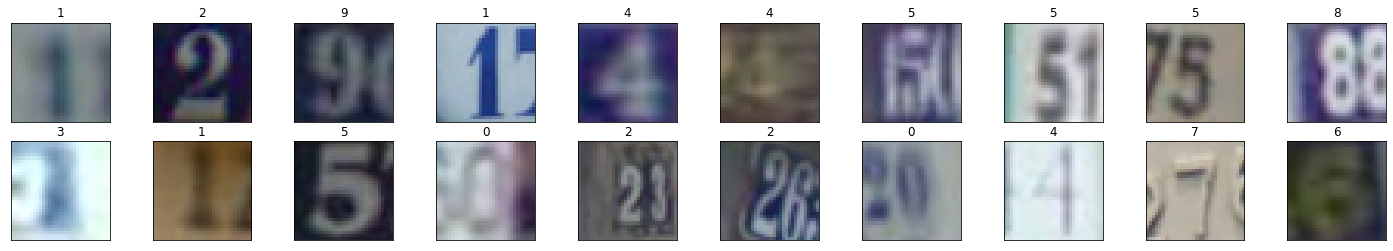

In [7]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    img = images[idx].numpy()
    img = img.transpose(1, 2, 0)
    ax.imshow(img.squeeze())
    ax.set_title(str(labels[idx].item()))

## Define the DCGAN model

### Generator

In [8]:
def frac_conv_layer(in_channels, out_channels, kernel_size, stride=2, padding=1, add_batch_norm=True):
    """
        A helper function to create a fractionally strided convolutional layer, 
        optionally followed by a batch_norm layer
    """
    layers = []
    frac_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
    layers.append(frac_conv)
    if add_batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [9]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32):
        super().__init__()
        
        self.conv_dim = conv_dim
        # fully connected layer to convert z vector into size that can be 
        # used for the first conv_layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.frac_conv_1 = frac_conv_layer(conv_dim*4, conv_dim*2, 4, add_batch_norm=True)
        self.frac_conv_2 = frac_conv_layer(conv_dim*2, conv_dim, 4, add_batch_norm=True)
        self.frac_conv_3 = frac_conv_layer(conv_dim, 3, 4, add_batch_norm=False)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = torch.relu(self.frac_conv_1(x))
        x = torch.relu(self.frac_conv_2(x))
        x = torch.tanh(self.frac_conv_3(x))
        
        return x

### Discriminator

In [10]:
def conv_layer(in_channels, out_channels, kernel_size, stride=2, padding=1, add_batch_norm=True):
    """
        A helper function to create a convolutional layer, 
        optionally followed by a batch_norm layer
    """
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
    layers.append(conv)
    if add_batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [31]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super().__init__()
    
        self.conv_dim = conv_dim
        
        self.conv1 = conv_layer(3, conv_dim, 4, add_batch_norm=False)
        self.conv2 = conv_layer(conv_dim, conv_dim*2, 4, add_batch_norm=True)
        self.conv3 = conv_layer(conv_dim*2, conv_dim*4, 4, add_batch_norm=True)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        
        return x

## Build the complete network

In [32]:
z_size = 100
conv_dim = 32

G = Generator(z_size, conv_dim)
D = Discriminator(conv_dim)
# put models on the GPU
G = G.to(device);
D = D.to(device);

## Weight Initialization
Initialize weights from a zero-centered normal distribution with a standard deviation of 0.2

In [33]:
def init_weights(module):
    """
    Takes in a module and initalizes all the weights with values taken from
    a zero-centered normal distribution with a standard deviation of 0.2
    
    Bias is initialized to zero
    """
    classname = module.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        if hasattr(module, 'weight'):
            module.weight.data.normal_(0.0, 0.2)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

In [34]:
G.apply(init_weights)
D.apply(init_weights)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

## Define loss functions and optimizers

In [35]:
def real_loss(logits, smooth=True):
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.ones(*logits.shape)*0.9 if smooth else torch.ones(*logits.shape)
    labels = labels.to(device)
    loss = criterion(logits, labels)
    return loss

In [36]:
def fake_loss(logits):
    labels = torch.zeros_like(logits)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    return criterion(logits, labels)

In [37]:
# use hyperparameters values recommended by the dcgan paper
lr = 0.0002
betas = (0.5, 0.999)

d_optimizer = optim.Adam(D.parameters(), lr, betas)
g_optimizer = optim.Adam(G.parameters(), lr, betas)

## Training Loop

In [38]:
n_epochs = 100
print_every = 400
generated_samples = []

discriminator_losses = []
generator_losses = []

In [39]:
# generate fixed z for evaluating the generator
fixed_z = np.random.uniform(-1, 1, size=(images.shape[0], z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)

In [40]:
for epoch in range(1, n_epochs+1):
    for idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        # scale images to be between the range -1 to 1
        real_images = real_images * 2 - 1
        
        ##############################################################
        #################   Train the Discriminator   ################
        ##############################################################
        d_optimizer.zero_grad()
        
        # pass real images to the discriminator
        real_logits = D(real_images)
        d_real_loss = real_loss(real_logits,smooth=False)
        
        # pass fake images to the discriminator 
        z = np.random.uniform(-1, 1, size=(images.shape[0], z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        
        fake_images = G(z)
        fake_logits = D(fake_images)
        d_fake_loss = fake_loss(fake_logits)
        
        # combine real and fake loss to get total discriminator loss
        d_loss = d_real_loss + d_fake_loss
        # backpropagate and update the gradients of the discriminator
        d_loss.backward()
        d_optimizer.step()
        
        ###############################################################
        #################   Train the Generator    ####################
        ###############################################################
        g_optimizer.zero_grad()
        
        # generate fake images 
        z = np.random.uniform(-1, 1, size=(images.shape[0], z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        
        fake_images = G(z)
        
        # pass fake images to the discriminator
        fake_logits = D(fake_images)
        g_loss = real_loss(fake_logits, smooth=False)
        
        # backpropagate and update the gradients of the generator
        g_loss.backward()
        g_optimizer.step()
        
        if idx % print_every == 0:
            discriminator_losses.append(d_loss.item())
            generator_losses.append(g_loss.item())
            # print statistics
            print(f'Epoch: {epoch}/{n_epochs}     Discriminator loss: {d_loss: .3f}',
                  f'    Generator loss: {g_loss: .3f}')
    else: 
        # generate and store sample images for this epoch
        G.eval() # put G in eval mode
        fake_images = G(fixed_z)
        generated_samples.append(fake_images)
        G.train() # put G in train mode

Epoch: 1/100     Discriminator loss:  5.776     Generator loss:  1.323
Epoch: 1/100     Discriminator loss:  0.488     Generator loss:  7.696
Epoch: 2/100     Discriminator loss:  0.504     Generator loss:  6.904
Epoch: 2/100     Discriminator loss:  0.537     Generator loss:  5.661
Epoch: 3/100     Discriminator loss:  0.495     Generator loss:  5.016
Epoch: 3/100     Discriminator loss:  0.484     Generator loss:  3.999
Epoch: 4/100     Discriminator loss:  0.432     Generator loss:  4.651
Epoch: 4/100     Discriminator loss:  0.462     Generator loss:  4.948
Epoch: 5/100     Discriminator loss:  0.757     Generator loss:  4.007
Epoch: 5/100     Discriminator loss:  0.445     Generator loss:  3.966
Epoch: 6/100     Discriminator loss:  0.495     Generator loss:  3.401
Epoch: 6/100     Discriminator loss:  0.714     Generator loss:  2.672
Epoch: 7/100     Discriminator loss:  0.544     Generator loss:  2.602
Epoch: 7/100     Discriminator loss:  0.502     Generator loss:  3.381
Epoch:

**save samples**

In [41]:
with open('saved_samples/svhn_samples_with_weight_init.pkl', 'wb') as f:
    pkl.dump(generated_samples, f)

## Plot training losses

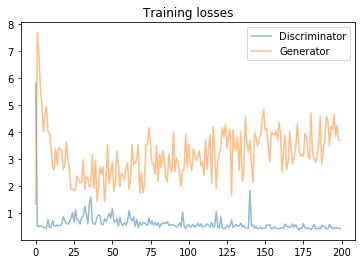

In [42]:
plt.plot(discriminator_losses, label='Discriminator', alpha=0.5)
plt.plot(generator_losses, label='Generator', alpha=0.5)
plt.title('Training losses')
plt.legend()

## Evaluate the model

#### Show generated samples

In [43]:
with open('saved_samples/svhn_samples_with_weight_init.pkl', 'rb') as f:
    generated_samples = pkl.load(f)

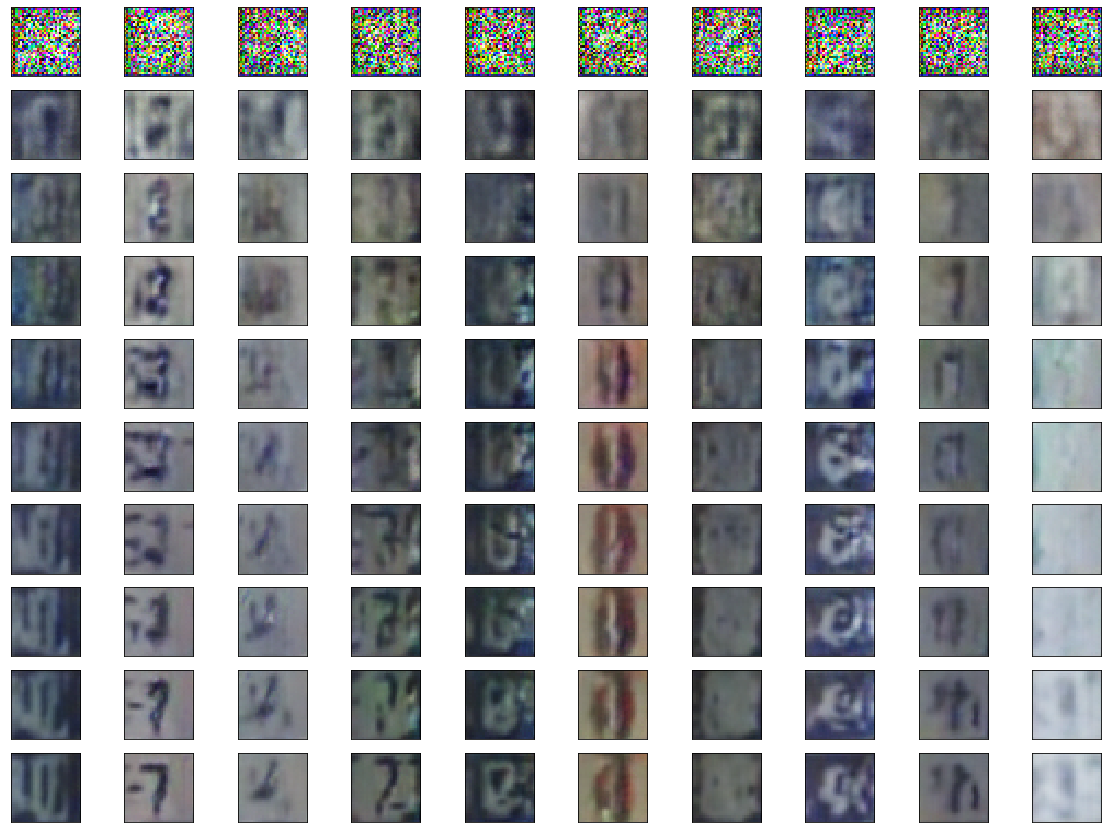

In [44]:
rows = 10
cols = 10

fig, ax = plt.subplots(figsize=(20, 15), nrows=rows, ncols=cols, sharex=True, sharey=True)


for epoch_sample, ax_row in zip(generated_samples[::int(len(generated_samples)/rows)], ax):
    for img, ax_col in zip(epoch_sample[::int(len(epoch_sample)/cols)], ax_row):
        img = img.cpu().detach() # detach tensor from its history
        img = img.numpy() # convert to numpy array
        img = img.transpose(1, 2, 0)
        img = ((img + 1) * 255 / (2)).astype(np.uint8) # rescale to 0-255
        ax_col.imshow(img)
        ax_col.xaxis.set_visible(False)
        ax_col.yaxis.set_visible(False)